# Backtesting with zipline - Pipeline API with Custom Data

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from logbook import Logger, StderrHandler, INFO, WARNING

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission, set_max_leverage,
                         order_target, order_target_percent,
                         get_open_orders, cancel_order)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader
from trading_calendars import get_calendar

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
np.random.seed(42)

In [4]:
DATA_PATH = Path('..', 'data')

### Load zipline extensions

Only need this in notebook to find bundle.

In [5]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [6]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=WARNING)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

In [7]:
N_LONGS = 10
N_SHORTS = 10
MIN_POSITIONS = 5

## Load Data

### Quandl Wiki Bundel

In [8]:
bundle_data = bundles.load('quandl')

### ML Predictions

In [9]:
def load_predictions(bundle):
    predictions = pd.read_hdf(DATA_PATH / 'predictions.h5', 'gradient_boosting')
    
    predictions = predictions[~predictions.index.duplicated()]
    tickers = predictions.index.get_level_values('ticker').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('ticker')
            .rename(columns=ticker_map)
            .tz_localize('UTC')), assets

In [10]:
predictions, assets = load_predictions(bundle_data)

In [11]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2014-01-09 to 2016-12-29
Columns: 500 entries, 0 to 3193
dtypes: float64(500)
memory usage: 2.9 MB


### Define Custom Dataset

In [12]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = US_EQUITIES

### Define Pipeline Loaders

In [13]:
signal_loader = {SignalData.predictions:
                     DataFrameLoader(SignalData.predictions, predictions)}

## Pipeline Setup

### Custom ML Factor

In [14]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, predictions):
        out[:] = predictions

### Create Pipeline

In [15]:
def compute_signals():
    signals = MLSignal()
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS, mask=signals > 0),
        'shorts': signals.bottom(N_SHORTS, mask=signals < 0)},
            screen=StaticAssets(assets))

## Initialize Algorithm

In [16]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.n_shorts = N_SHORTS
    context.min_positions = MIN_POSITIONS
    context.universe = assets
    context.trades = pd.Series()
    context.longs = context.shorts = 0
    
    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0.001, min_trade_cost=0))

    schedule_function(rebalance,
                      date_rules.every_day(),
#                       date_rules.week_start(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

### Get daily Pipeline results

In [17]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    df = (output['longs'].astype(int)
                      .append(output['shorts'].astype(int).mul(-1)))
    
    holdings = df[df!=0]
    other = df[df==0]
    other = other[~other.index.isin(holdings.index) & ~other.index.duplicated()]
    context.trades = holdings.append(other)
    assert len(context.trades.index.unique()) == len(context.trades)

## Define Rebalancing Logic

In [18]:
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    trades = defaultdict(list)
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
      
    positions = context.portfolio.positions
    s=pd.Series({s:v.amount*v.last_sale_price for s, v in positions.items()}).sort_values(ascending=False)
    for stock, trade in context.trades.items():
        if trade == 0:
            order_target(stock, target=0)
        else:
            trades[trade].append(stock)
    
    context.longs, context.shorts = len(trades[1]), len(trades[-1])
#     log.warning('{} {:,.0f}'.format(len(positions), context.portfolio.portfolio_value))
    if context.longs > context.min_positions and context.shorts > context.min_positions:
        for stock in trades[-1]:
            order_target_percent(stock, -1 / context.shorts)
        for stock in trades[1]:
            order_target_percent(stock, 1 / context.longs)
    else:
        for stock in trades[-1] + trades[1]:
            if stock in positions:
                order_target(stock, 0)

## Record Data Points

In [19]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

## Run Algorithm

In [20]:
dates = predictions.index.get_level_values('date')
start_date, end_date = dates.min(), dates.max()

In [21]:
print('Start: {}\nEnd:   {}'.format(start_date.date(), end_date.date()))

Start: 2014-01-09
End:   2016-12-29


In [22]:
start = time()
results = run_algorithm(start=pd.Timestamp('2014-01-12', tz='UTC'),
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e5,
                        data_frequency='daily',
                        bundle='quandl',
                        custom_loader=signal_loader)  # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

[2020-12-30 17:56:56.121407]: WARNING: _load_cached_data: Refusing to download new benchmark data because a download succeeded at 2020-12-30 17:44:29.013131+00:00.
[2020-12-30 17:56:56.156703]: WARNING: _load_cached_data: Refusing to download new treasury data because a download succeeded at 2020-12-30 17:44:31.165131+00:00.


Duration: 40.11s


## PyFolio Analysis

In [23]:
benchmark = web.DataReader('SP500', 'fred', '2013', '2017').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

In [24]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results['2011':'2016'])

### Custom Plots

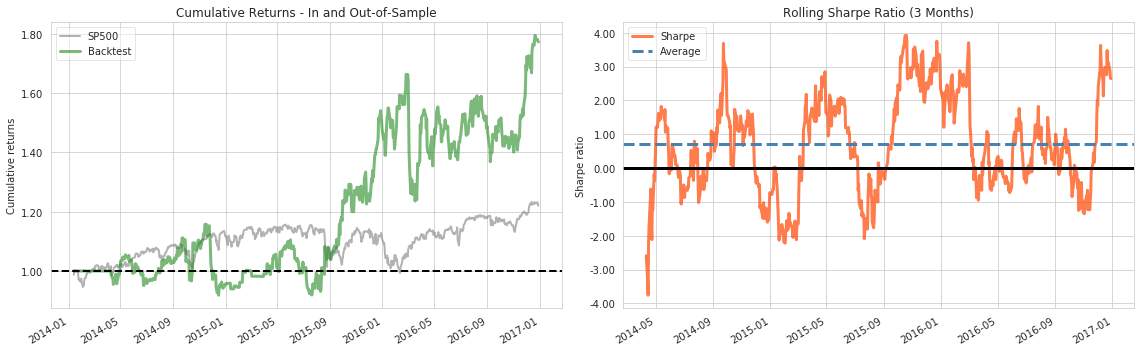

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                     ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
fig.tight_layout()

### Tear Sheets

Start date,2014-01-13
End date,2016-12-29
Total months,35
,Backtest
Annual return,21.3%
Cumulative returns,77.3%
Annual volatility,29.0%
Sharpe ratio,0.81
Calmar ratio,0.83
Stability,0.74
Max drawdown,-25.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,25.71,2016-02-26,2016-03-17,2016-11-30,199
1,20.67,2014-11-17,2014-12-16,2015-09-25,225
2,13.09,2014-09-23,2014-10-14,2014-11-11,36
3,9.79,2014-05-13,2014-06-25,2014-09-11,88
4,9.79,2015-12-28,2016-01-08,2016-01-14,14


Stress Events,mean,min,max
Apr14,0.08%,-2.16%,2.37%
Oct14,0.14%,-5.78%,9.32%
Fall2015,0.61%,-3.04%,9.52%
New Normal,0.09%,-8.61%,9.52%


Top 10 long positions of all time,max
sid,
GRMN,17.30%
HSY,17.29%
CRM,17.26%
CREE,17.21%
CPB,17.19%
MYL,17.15%
HRB,17.01%
WYNN,16.95%
SUNE,16.94%


Top 10 short positions of all time,max
sid,
UPL,-20.19%
ACI,-19.60%
WLT,-18.84%
ANR,-18.73%
PTEN,-17.96%
MRO,-17.31%
APC,-17.31%
ED,-17.14%
SO,-17.08%


Top 10 positions of all time,max
sid,
UPL,20.19%
ACI,19.60%
WLT,18.84%
ANR,18.73%
PTEN,17.96%
MRO,17.31%
APC,17.31%
GRMN,17.30%
HSY,17.29%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,9877.00,4945.00,4932.00
Percent profitable,0.50,0.50,0.51
Winning round_trips,4973.00,2479.00,2494.00
Losing round_trips,4792.00,2404.00,2388.00
Even round_trips,112.00,62.00,50.00


PnL stats,All trades,Short trades,Long trades
Total profit,$96710.80,$71228.90,$25481.90
Gross profit,$1421241.29,$753073.25,$668168.04
Gross loss,$-1324530.49,$-681844.34,$-642686.14
Profit factor,$1.07,$1.10,$1.04
Avg. trade net profit,$9.79,$14.40,$5.17
Avg. winning trade,$285.79,$303.78,$267.91
Avg. losing trade,$-276.40,$-283.63,$-269.13
Ratio Avg. Win:Avg. Loss,$1.03,$1.07,$1.00
Largest winning trade,$7722.48,$7722.48,$7354.11
Largest losing trade,$-10159.05,$-10159.05,$-5592.09


Duration stats,All trades,Short trades,Long trades
Avg duration,1 days 22:29:56.172117,1 days 23:56:36.885136,1 days 21:03:01.750811
Median duration,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00
Longest duration,266 days 04:00:01,266 days 04:00:01,20 days 00:00:00
Shortest duration,0 days 03:00:01,0 days 03:00:01,0 days 03:00:01


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.01%,0.01%,0.01%
Avg returns winning,0.22%,0.24%,0.21%
Avg returns losing,-0.21%,-0.22%,-0.21%
Median returns all round_trips,0.00%,0.00%,0.00%
Median returns winning,0.12%,0.13%,0.11%
Median returns losing,-0.12%,-0.12%,-0.12%
Largest winning trade,7.44%,5.63%,7.44%
Largest losing trade,-7.51%,-7.51%,-4.00%


Symbol stats,A,AAL,AAP,AAPL,ABC,ABT,ACI,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEO,AEP,AES,AET,AFL,AGCO,AGN,AIG,AKAM,AKS,ALL,ALTR,ALXN,AMAT,AMD,AMG,AMGN,AMP,AMT,AMTD,AMZN,ANF,ANR,ANTM,AON,APA,APC,APD,APH,APOL,ARNC,ASH,ATI,ATVI,AVB,AVP,AXP,AZO,BA,BAC,BAX,BBBY,BBT,BBY,BCR,BDX,BEAM,BEN,BG,BHI,BIDU,BIIB,BK,BLK,BMRN,BMY,BP,BRCD,BRCM,BSX,BTU,BWA,BXP,C,CA,CAG,CAH,CAM,CAT,CB,CBG,CBS,CCE,CCI,CCL,CE,CELG,CERN,CF,CHK,CHKP,CHRW,CI,CIEN,CL,CLF,CLR,CLX,CMA,CMCSA,CMCSK,CME,CMG,CMI,CMS,CNP,CNX,COF,COG,COH,COL,COP,COST,CPB,CPN,CREE,CRM,CSCO,CSX,CTL,CTSH,CTXS,CVS,CVX,CXO,D,DAL,DD,DE,DECK,DF,DFS,DGX,DHI,DHR,DIS,DISCA,DISH,DKS,DLTR,DNR,DO,DOV,DOW,DPS,DRI,DTE,DTV,DUK,DVA,DVN,EA,EBAY,ECL,ED,EIX,EL,EMC,EMN,EMR,ENDP,EOG,EQIX,EQR,EQT,ESRX,ESV,ETFC,ETN,ETR,EW,EXC,EXPD,EXPE,F,FAST,FCX,FDO,FDX,FE,FFIV,FIS,FISV,FITB,FL,FLR,FLS,FOX,FOXA,FRX,FSLR,FTI,GD,GE,GGP,GILD,GIS,GLW,GMCR,GME,GNW,GOOGL,GPS,GRMN,GS,GT,GWW,HAL,HAS,HBAN,HCN,HCP,HD,HES,HFC,HIG,HOG,HOLX,HON,HOT,HP,HPQ,HRB,HSH,HST,HSY,HTZ,HUM,IACI,IBM,ICE,IGT,ILMN,INTC,INTU,IP,IPG,IR,ISRG,IVZ,JBHT,JBLU,JCI,JCP,JDSU,JEC,JNJ,JNPR,JOY,JPM,JWN,K,KBH,KEY,KIM,KLAC,KMB,KMX,KO,KR,KSS,KSU,L,LB,LBTYA,LEN,LH,LINTA,LLL,LLTC,LLY,LM,LMT,LNC,LOW,LRCX,LUV,LVLT,LVS,M,MA,MAS,MAT,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,MGM,MHK,MJN,MLM,MMC,MMM,MNST,MO,MON,MOS,MRK,MRO,MRVL,MS,MSFT,MSI,MTB,MU,MUR,MXIM,MYL,NBL,NBR,NDAQ,NE,NEE,NEM,NFLX,NFX,NKE,NLY,NOC,NOV,NRG,NSC,NTAP,NTRS,NUAN,NUE,NVDA,NWL,OCR,OMC,ONNN,ORCL,ORLY,OXY,PAYX,PCAR,PCG,PCLN,PCP,PEG,PEP,PETM,PFE,PFG,PG,PGR,PH,PHM,PLD,PM,PNC,PNRA,PPG,PPL,PRGO,PRU,PSA,PTEN,PVH,PWR,PX,PXD,QCOM,RAI,RCL,RDC,RF,RHT,RIG,RL,ROK,ROST,RRC,RSG,RTN,RVBD,S,SBAC,SBUX,SCCO,SCHW,SE,SHW,SIAL,SIRI,SLB,SLG,SLM,SNDK,SO,SPG,SPLS,SRE,STI,STJ,STLD,STT,STX,STZ,SUNE,SWK,SWKS,SWN,SWY,SYK,SYMC,SYY,T,TAP,TDC,TEL,TEX,TGT,THC,TIF,TJX,TMO,TMUS,TOL,TROW,TRV,TSN,TSO,TWC,TWX,TXN,TXT,TYC,UAA,UAL,UHS,UNH,UNM,UNP,UPL,UPS,URBN,URI,USB,UTHR,UTX,V,VAR,VFC,VIAB,VLO,VMC,VMW,VNO,VOD,VRSN,VRTX,VRX,VTR,WAG,WAT,WBA,WDC,WFC,WFM,WHR,WLL,WLT,WM,WMB,WMT,WSM,WU,WY,WYN,WYNN,X,XEC,XEL,XLNX,XRX,YHOO,YUM,ZBH,ZION,ZMH
Avg returns all round_trips,0.01%,-0.03%,-0.01%,-0.02%,-0.03%,-0.01%,0.18%,nan%,0.02%,0.12%,-0.05%,-0.08%,0.03%,-0.01%,0.01%,0.10%,0.04%,-0.09%,0.09%,-0.02%,-0.02%,0.26%,-0.08%,-0.04%,0.05%,-0.01%,-0.03%,-0.02%,0.16%,-0.01%,0.01%,0.04%,-0.01%,-0.04%,0.01%,-0.01%,0.11%,0.09%,0.05%,0.04%,0.02%,-0.02%,0.05%,0.02%,-0.04%,0.00%,-0.01%,-0.03%,0.14%,0.06%,0.07%,0.03%,0.03%,0.01%,-0.05%,-0.04%,-0.10%,-0.02%,0.04%,-0.06%,-0.00%,-0.17%,-0.01%,0.00%,0.02%,0.06%,0.09%,0.05%,0.04%,-0.06%,0.04%,0.00%,-0.06%,-0.03%,0.01%,-0.07%,nan%,-0.30%,0.11%,0.07%,0.02%,0.27%,0.18%,0.06%,0.03%,-0.12%,0.02%,0.01%,0.03%,-0.08%,-0.02%,0.02%,-0.01%,0.04%,nan%,0.07%,-0.02%,0.10%,-0.02%,0.06%,0.01%,0.01%,0.20%,0.04%,0.03%,0.10%,-0.01%,-0.01%,0.02%,0.08%,0.02%,0.05%,-0.01%,-0.02%,-0.08%,-0.02%,0.01%,-0.01%,0.01%,0.02%,-0.00%,-0.07%,-0.14%,-0.09%,0.04%,-0.02%,-0.05%,-0.11%,0.11%,0.07%,-0.01%,0.07%,0.01%,-0.01%,0.01%,0.10%,-0.01%,0.07%,-0.02%,0.08%,-0.07%,-0.08%,0.05%,-0.04%,-0.02%,0.09%,0.04%,-0.02%,0.09%,0.00%,0.02%,-0.01%,-0.03%,-0.06%,-0.03%,0.04%,-0.01%,nan%,-0.04%,0.07%,0.03%,0.11%,-0.02%,0.06%,-0.01%,0.01%,0.04%,0.02%,-0.02%,-0.02%,0.01%,-0.00%,0.06%,-0.03%,0.01%,0.01%,-0.03%,0.03%,0.08%,0.05%,0.02%,0.03%,0.08%,0.07%,-0.11%,-0.05%,-0.04%,0.02%,-0.03%,-0.07%,-0.09%,-0.02%,0.07%,0.04%,0.04%,0.13%,-0.03%,-0.02%,-0.02%,-0.00%,0.09%,-0.04%,0.05%,0.03%,-0.01%,-0.01%,-0.05%,-0.03%,0.14%,0.05%,0.02%,-0.07%,-0.10%,0.14%,0.05%,0.01%,0.02%,0.03%,-0.01%,0.00%,-0.03%,0.03%,-0.32%,0.10%,0.06%,-0.10%,-0.04%,-0.11%,-0.02%,-0.03%,0.01%,-0.01%,0.00%,-0.02%,0.01%,0.01%,0.02%,0.02%,0.14%,-0.08%,0.09%,0.03%,0.00%,0.01%,0.04%,-0.02%,-0.01%,0.02%,0.03%,-0.02%,-0.01%,0.02%,-0.05%,0.00%,-0.00%,0.03%,-0.01%,0.13%,-0.24%,-0.02%,0.00%,0.05%,0.07%,0.02%,0.06%,-0.06%,-0.05%,-0.11%,-0.08%,-0.06%,0.10%,-0.20%,0.02%,-0.07%,0.16%,0.02%,-0.05%,-0.06%,-0.07%,-0.01%,0.04%,0.03%,0.01%,-0.16%,0.06%,0.00%,0.09%,-0.04%,-0.07%,0.26%,0.01%,0.00%,0.00%,-0.05%,-0.08%,0.01%,0.04%,0.05%,-0.01%,-0.20%,0.05%,-0.08%,0.11%,-0

Profitability (PnL / PnL total) per name,
symbol,
AMD,18.29%
ACI,16.03%
AVP,11.84%
CLF,11.00%
S,9.05%
DO,8.63%
ANR,8.46%
THC,7.98%
CHK,7.45%


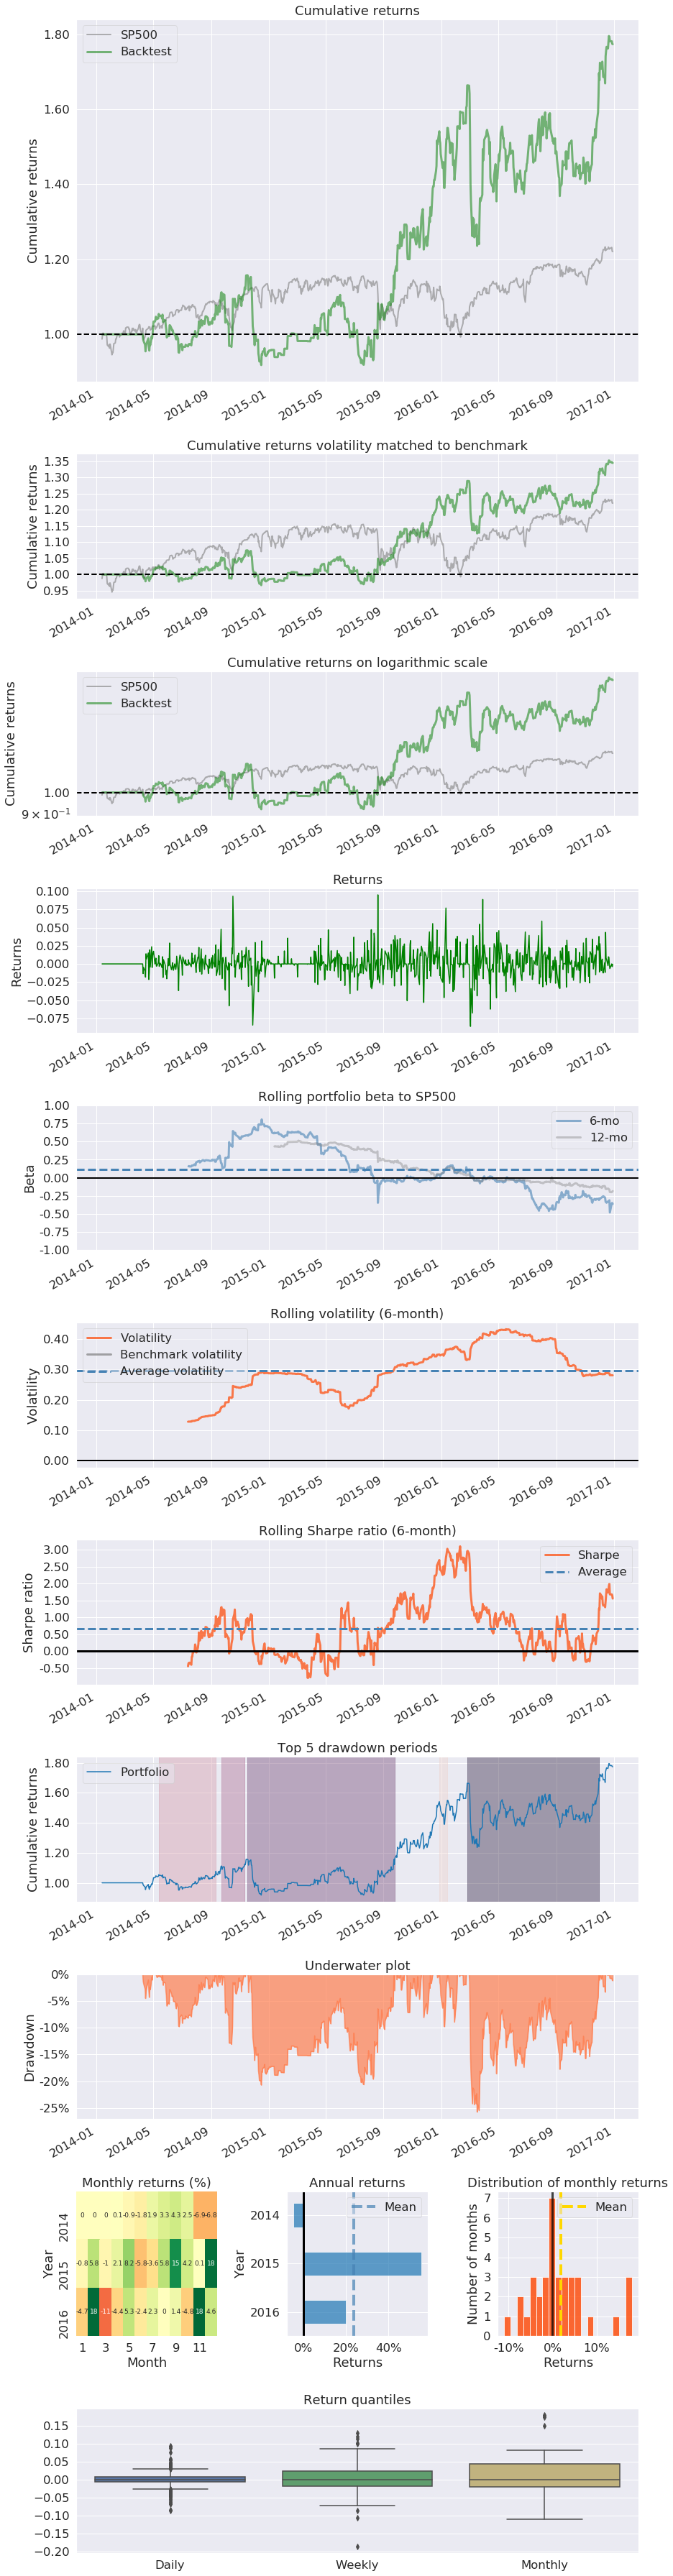

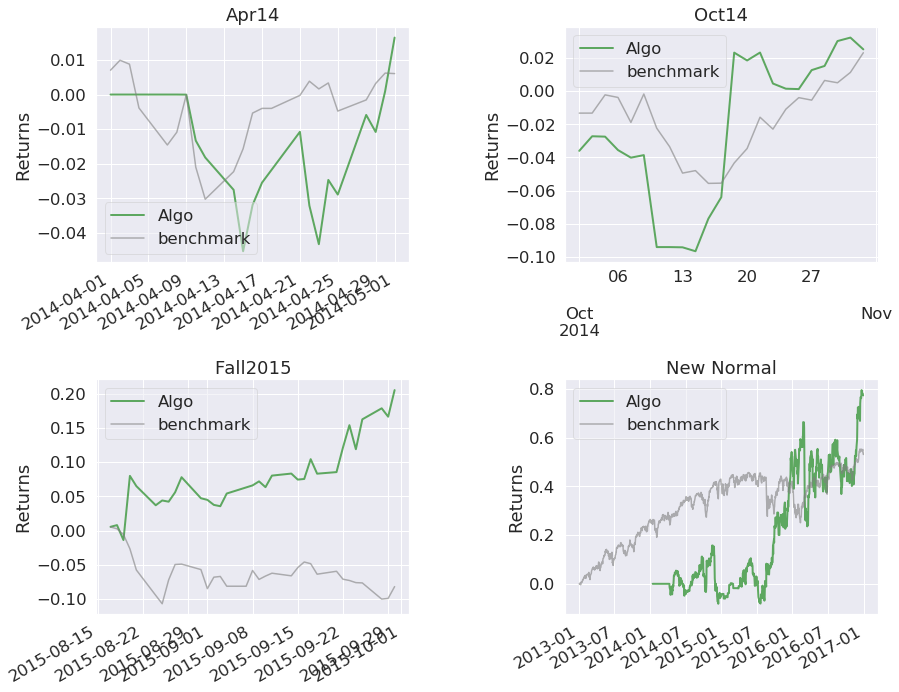

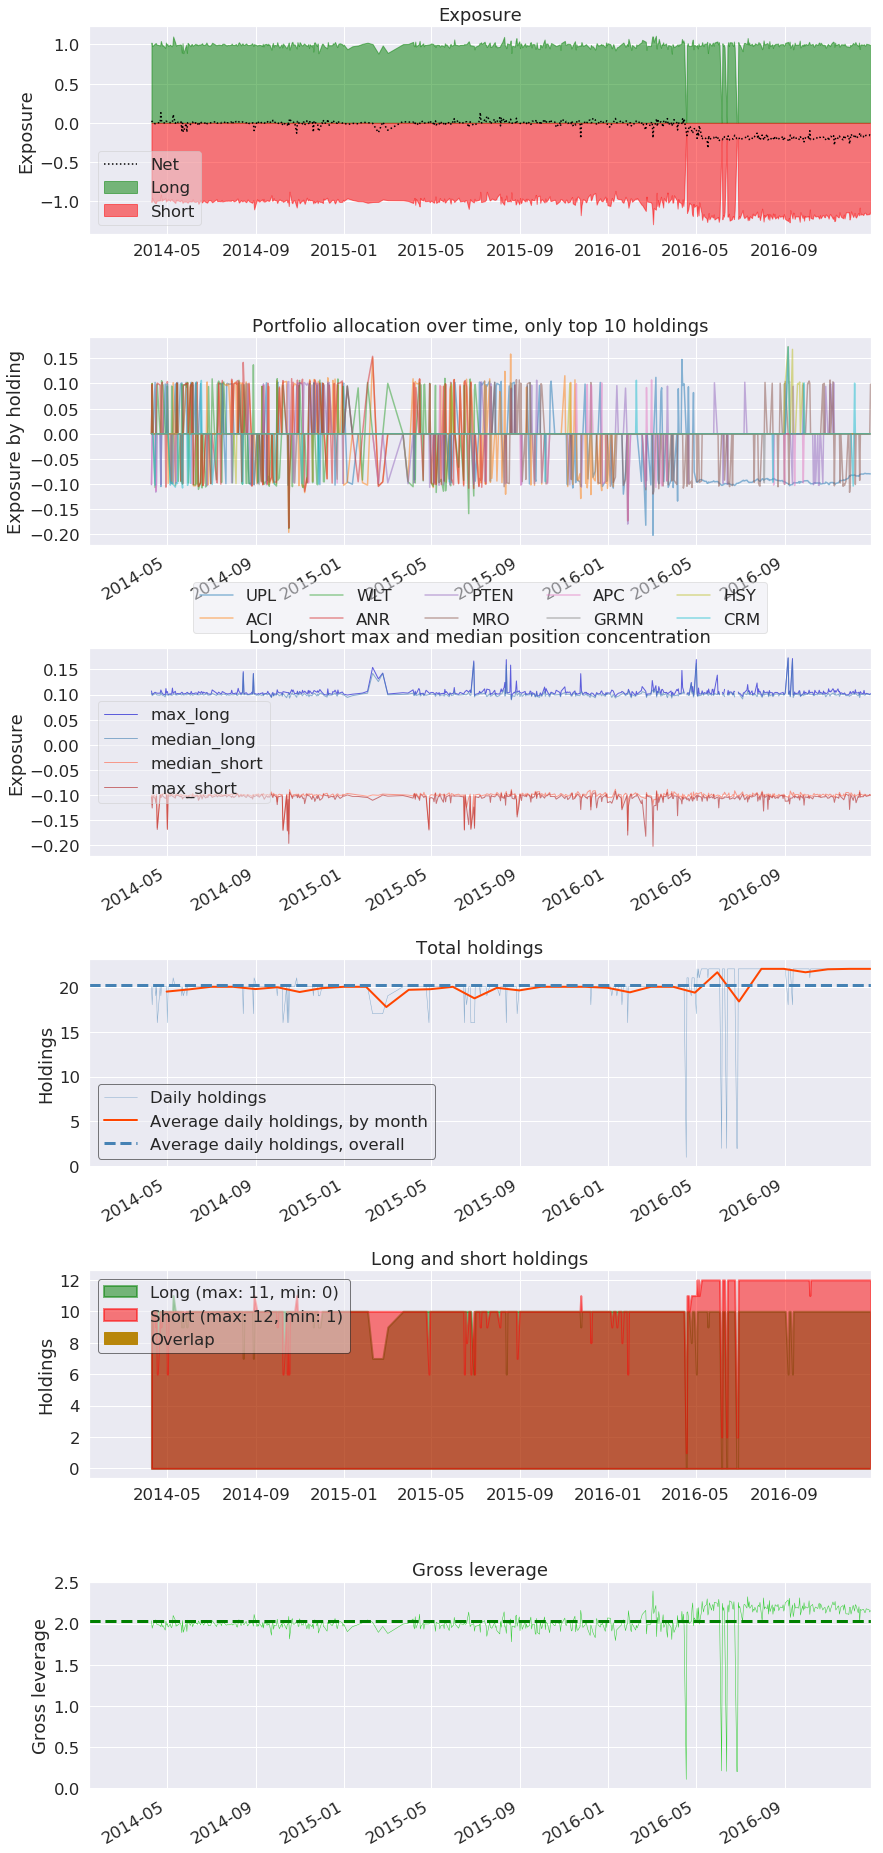

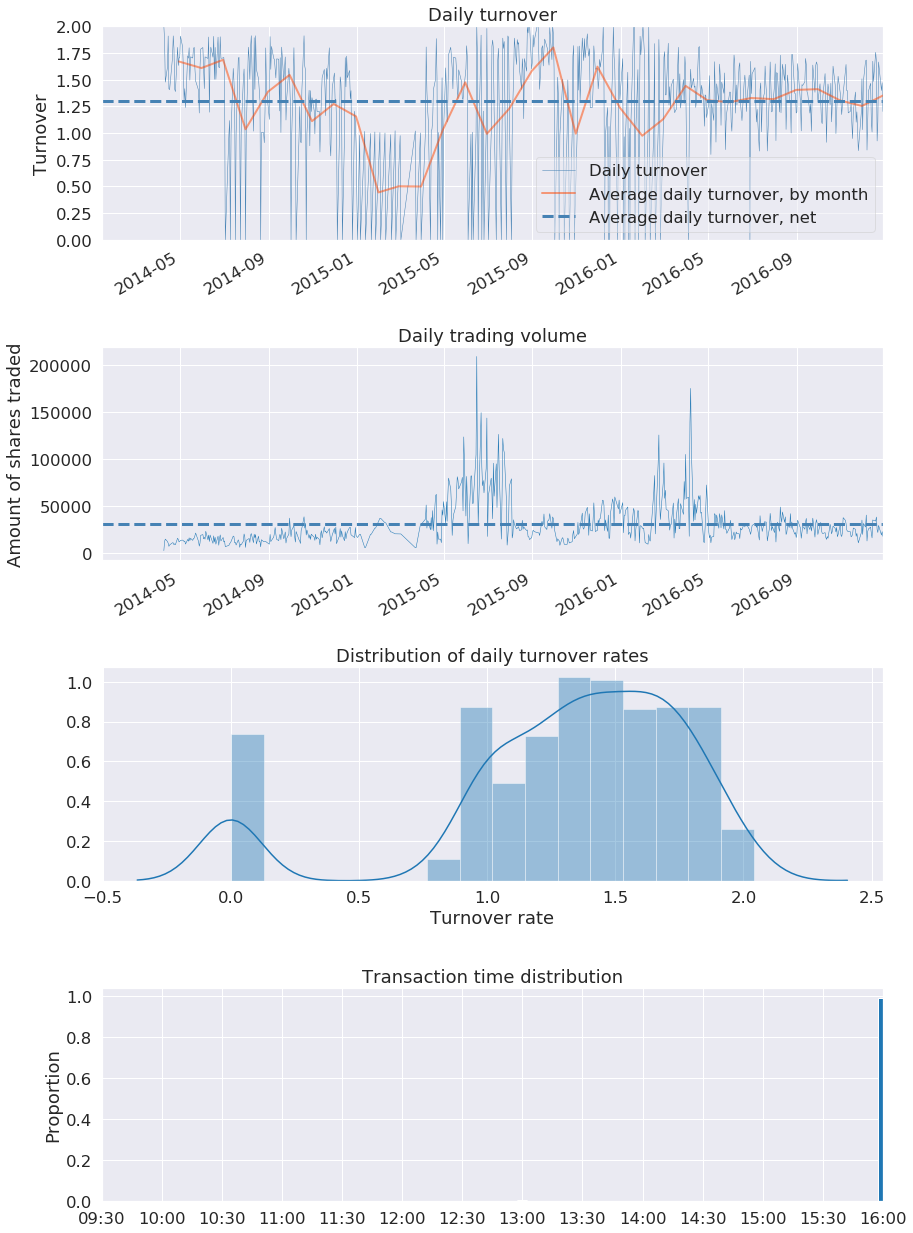

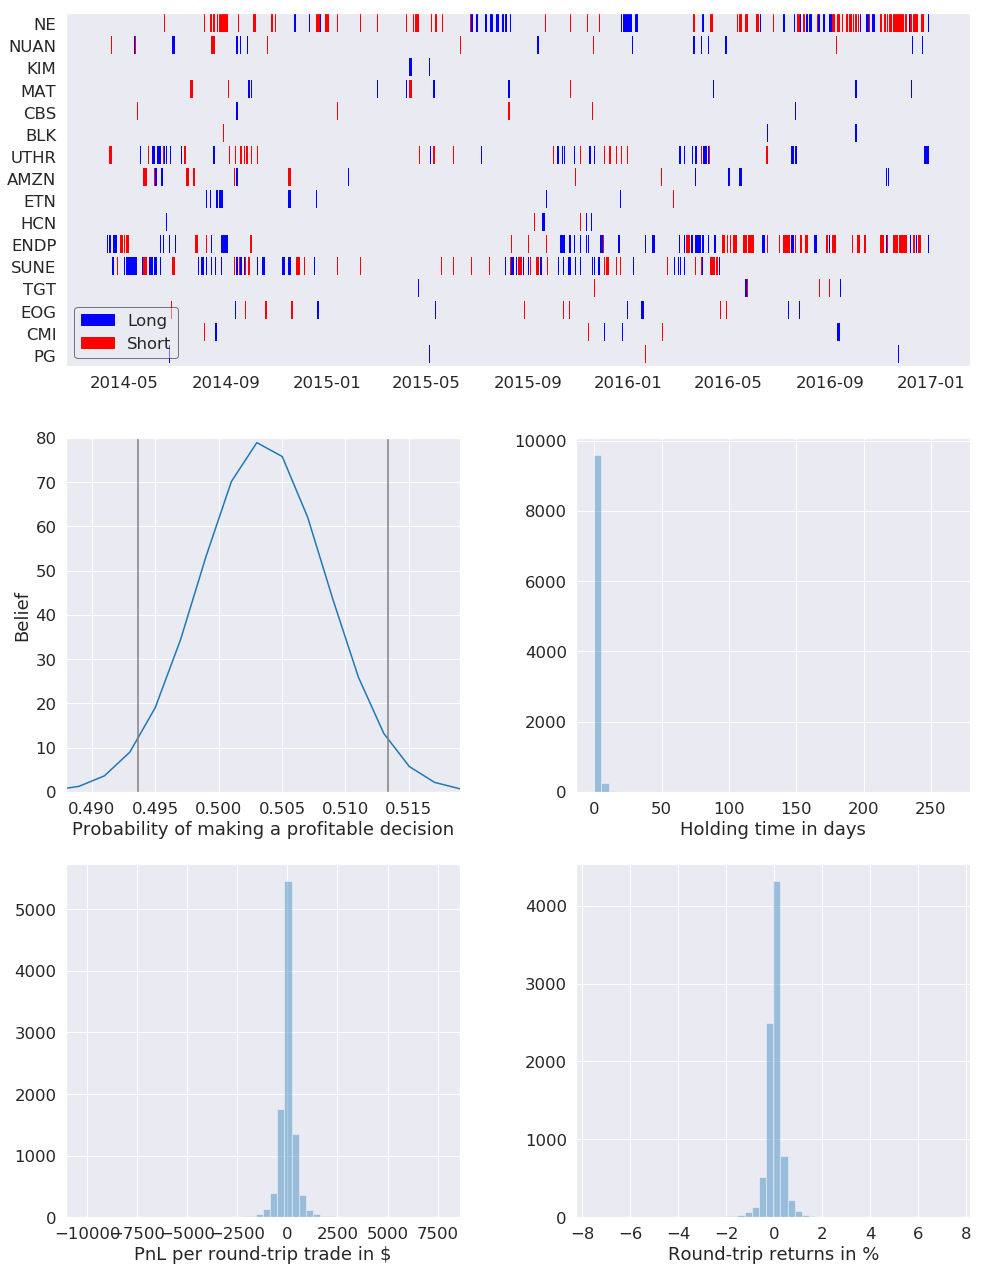

In [26]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          round_trips=True)